## Desafio
### Questão 1

In [14]:
!unzip zipado.zip

Archive:  zipado.zip
  inflating: .ipynb_checkpoints/Desafio-checkpoint.ipynb  
  inflating: 000000/000000_points.obj  
  inflating: 000001/000001_points.obj  
  inflating: 000002/000002_points.obj  
  inflating: 000003/000003_points.obj  
  inflating: 000004/000004_points.obj  
  inflating: 000005/000005_points.obj  
  inflating: 000006/000006_points.obj  
  inflating: 000007/000007_points.obj  
  inflating: 000008/000008_points.obj  
  inflating: 000009/000009_points.obj  
  inflating: 000010/000010_points.obj  
  inflating: 000011/000011_points.obj  
  inflating: 000012/000012_points.obj  
  inflating: 000013/000013_points.obj  
  inflating: 000014/000014_points.obj  
  inflating: 000015/000015_points.obj  
  inflating: 000016/000016_points.obj  
  inflating: 000017/000017_points.obj  
  inflating: 000018/000018_points.obj  
  inflating: 000019/000019_points.obj  
  inflating: 000020/000020_points.obj  
  inflating: 000021/000021_points.obj  
  inflating: 000022/000022_points.obj  


In [11]:
!pip install trimesh
!pip install chainer
!pip install cupy-cuda101

In [4]:
import numpy as np
import trimesh
from tempfile import mkdtemp
import os.path as path
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import os
import cv2 as cv
from torchvision import transforms
import PIL as pil
import tensorflow as tf
from tensorflow import keras

In [2]:
point_cloud1 = trimesh.load('./000000/000000_points.obj').vertices
point_cloud2 = trimesh.load('./000001/000001_points.obj').vertices
ground_truth = np.load('ground_truth.npy')

In [3]:
point_cloud1.shape

(62553, 3)

In [4]:
point_cloud2.shape

(62340, 3)

In [173]:
def icp(A, B, max_iterations=100, tolerance=0.001):
    """
    Iterative Closest Point algorithm.
    A and B are point sets, represented as (N, D) arrays, where N is the number of points and D is the dimension.
    max_iterations is the maximum number of iterations.
    tolerance is the convergence threshold.
    """
    # Initialize nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(B)
    T = np.eye(4)
    iterations = 0
    converged = False
    while not converged and iterations < max_iterations:
        # Find closest points
        distances, indices = nbrs.kneighbors(A)
        # calculate centroids

        # A_centroid = np.mean(A, axis=0).reshape(1,-1).repeat(A.shape[0], axis=0)
        # B_centroid = B[indices].reshape(-1, 3)
        A_centroid = np.mean(A, axis = 0)
        B_centroid = np.mean(B[indices.ravel()], axis = 0)
        # calculate covariance
        # H = np.zeros((A.shape[1], A.shape[1]))
        # for i in range(A.shape[0]):
          # H += (A[i] - A_centroid).T.dot(B[indices[i]] - B_centroid)
        H = np.dot((A - A_centroid).T, (B[indices.ravel()] - B_centroid))


        # calculate best rotation
        U, S, Vt = np.linalg.svd(H)
        R = np.dot(Vt.T, U.T)
        # calculate best translation
        t = B_centroid.T - np.dot(R, A_centroid.T)
        # update transformation matrix
        T[:3, :3] = R
        T[:3, 3:] = np.expand_dims(t, axis=1)

        # update points
        A = np.dot(A, R) + t.T
        # check for convergence
        mean_distance = np.mean(distances)
        if mean_distance < tolerance:
            converged = True
        iterations += 1

    return T, iterations

In [188]:
df = pd.DataFrame(columns=['matriz_icp','error'])

for i in range(29):
  
  if i >= 10:
    point_cloud1 = trimesh.load(f'./0000{i}/0000{i}_points.obj').vertices
    point_cloud2 = trimesh.load(f'./0000{i+1}/0000{i+1}_points.obj').vertices
  
  if i == 9:

    point_cloud1 = trimesh.load(f'./00000{i}/00000{i}_points.obj').vertices
    point_cloud2 = trimesh.load(f'./0000{i+1}/0000{i+1}_points.obj').vertices

  if i <= 8:
    point_cloud1 = trimesh.load(f'./00000{i}/00000{i}_points.obj').vertices
    point_cloud2 = trimesh.load(f'./00000{i+1}/00000{i+1}_points.obj').vertices

  transformation , it = icp(point_cloud1, point_cloud2)
  error = np.mean((transformation - ground_truth[i])**2)

  df.loc[len(df)] = [transformation, error]


In [194]:
df.to_csv('matriz_icp.csv')

In [193]:
df['matriz_icp'][0]

array([[ 0.98280557, -0.02413677, -0.18305909, -0.56743014],
       [ 0.01751321,  0.99913511, -0.03771362, -0.70552995],
       [ 0.18381105,  0.0338592 ,  0.98237826, -0.4254228 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [215]:
def plot_icp_single(A, B, T):
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(B)
    distances, indices = nbrs.kneighbors(A.dot(T[:3, :3].T) + T[:3, 3])

    index = np.argmin(distances)
    A_transformed = A[index]
    B_transformed = B[indices[index][0]]

    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(A_transformed[0], A_transformed[1], A_transformed[2], c='b', marker='o')
    ax.scatter(B_transformed[0], B_transformed[1], B_transformed[2], c='r', marker='o')
    ax.plot([A_transformed[0], B_transformed[0]], [A_transformed[1], B_transformed[1]], [A_transformed[2], B_transformed[2]], c='g')
    plt.show()


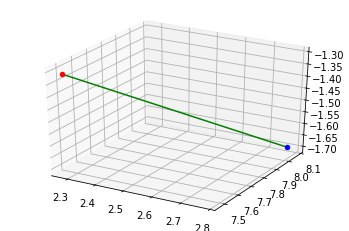

In [216]:

for i in range(29):
  
  if i >= 10:
    point_cloud1 = trimesh.load(f'./0000{i}/0000{i}_points.obj').vertices
    point_cloud2 = trimesh.load(f'./0000{i+1}/0000{i+1}_points.obj').vertices
  
  if i == 9:

    point_cloud1 = trimesh.load(f'./00000{i}/00000{i}_points.obj').vertices
    point_cloud2 = trimesh.load(f'./0000{i+1}/0000{i+1}_points.obj').vertices

  if i <= 8:
    point_cloud1 = trimesh.load(f'./00000{i}/00000{i}_points.obj').vertices
    point_cloud2 = trimesh.load(f'./00000{i+1}/00000{i+1}_points.obj').vertices

  T = df['matriz_icp'][i]

  plot_icp_single(point_cloud1, point_cloud2, T)

### Questão 2

In [217]:
!unzip post-processed.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: post-processed/Michael_Goldrich/Michael_Goldrich_0001_0000.jpg  
  inflating: post-processed/Michael_Goldrich/Michael_Goldrich_0001_0001.jpg  
  inflating: post-processed/Michael_Goldrich/Michael_Goldrich_0002_0000.jpg  
  inflating: post-processed/Michael_Goldrich/Michael_Goldrich_0002_0001.jpg  
  inflating: post-processed/Michael_Goldrich/Michael_Goldrich_0002_0002.jpg  
   creating: post-processed/Michael_Hagee/
  inflating: post-processed/Michael_Hagee/Michael_Hagee_0001_0000.jpg  
  inflating: post-processed/Michael_Hagee/Michael_Hagee_0002_0000.jpg  
   creating: post-processed/Michael_Haneke/
  inflating: post-processed/Michael_Haneke/Michael_Haneke_0001_0000.jpg  
  inflating: post-processed/Michael_Haneke/Michael_Haneke_0001_0001.jpg  
  inflating: post-processed/Michael_Haneke/Michael_Haneke_0002_0000.jpg  
  inflating: post-processed/Michael_Haneke/Michael_Haneke_0004_0000.jpg  
  inflating: post-proces

In [2]:
paths = os.listdir('./post-processed')
img = os.listdir('./post-processed/' + paths[0])[1]

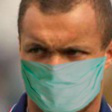

In [3]:



# creating a object
im = pil.Image.open('./post-processed/' + paths[0] + '/' + img)
  
im

In [4]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
      
    img_pil = pil.Image.open(image)
    img_transform = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])
    
    image = img_transform(img_pil)
    
    return image

In [5]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

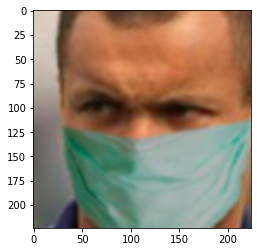

In [6]:
new_img = process_image('./post-processed/' + paths[0] + '/' + img)
imshow(new_img)

In [7]:
new_img.shape

torch.Size([3, 224, 224])

In [8]:
lista_img = []

In [9]:
images = []

In [10]:
for pasta in paths:
  path_imgs = os.listdir('./post-processed/' + pasta)

  for img in path_imgs:
    lista_img.append('./post-processed/' + pasta + '/' + img)
    # df.loc[len(df)] = ['./post-processed/' + pasta + '/' + img]

In [11]:
for img in lista_img:

  new_img = process_image(img)
  new_img = new_img.numpy().transpose((1,2,0))
  new_img = tf.convert_to_tensor(new_img , dtype=tf.float32)
  new_img = tf.image.rgb_to_grayscale(new_img)
  images.append(new_img)

In [12]:
images = tf.Variable(images)

In [13]:
images.shape

TensorShape([12000, 224, 224, 1])

In [14]:
np.save('images.npy', images)

In [2]:
import numpy as np
images = np.load('images.npy')

FileNotFoundError: ignored

In [1]:
images = tf.convert_to_tensor(images)

NameError: ignored

In [11]:
images = tf.reshape(images, [12000, 224, 224])

In [ ]:
input_shape = (224, 224, 1)
model = tf.keras.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(224*224))
model.add(keras.layers.Reshape((224,224,1)))

# Compilando o modelo para auto-encode
model.compile(optimizer='adam', loss='mse') 

# Carregando o conjunto de dados de imagens

# Treinando o modelo
model.fit(images, images, epochs=5, batch_size=32)

# obtendo a representação interna
representation_layer = model.get_layer("dense_2")
representation_model = tf.keras.Model(inputs=model.input, outputs=representation_layer.output)

# gerando as representações
representations = representation_model.predict(images)


Epoch 1/10
375/375 [==============================] - 32s 56ms/step - loss: 0.3725
Epoch 2/10
375/375 [==============================] - 21s 55ms/step - loss: 0.2575
Epoch 3/10
375/375 [==============================] - 21s 55ms/step - loss: 0.2516
Epoch 4/10
 77/375 [=====>........................] - ETA: 16s - loss: 0.2471